# Questions Classifier

Kelompok B - IF5172 Datawarehouse & Data Mining
- Anindya Prameswari			13518034
- William Fu 				13518055
- Hollyana Puteri Haryono		18218013
- Adriel Gustino P. Situmorang		18218047
- Arief Purnama Muharram		23521013

In [1]:
!pip install --upgrade nltk
!pip install gensim==3.6.0
!pip install xgboost

In [2]:
# import necessary package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore")
import pickle

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TEMP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TEMP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading Dataset

In [3]:
df = pd.read_csv('dataset2.csv')
df.head()

,label,question
0,5,Bagaimana cara mengobati penyakit Grave's?
1,5,Apa obat untuk penyakit Grave's?
2,5,Obat apa yang dapat menyembuhkan penyakit Grav...
3,3,Apa gejala terkena penyakit Grave's?
4,3,Bagaimana tanda-tanda terkena penyakit Grave's?


<AxesSubplot:>

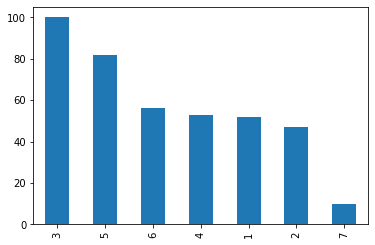

In [4]:
# Summary
df['label'].value_counts().plot(kind='bar')

## Data Preprocessing

In [5]:
# read the dictionary of slang-formal words
df_formal_words = pd.read_csv('colloquial-indonesian-lexicon.csv')
slangs_words = df_formal_words[['slang','formal']] 

In [6]:
df['question_clean'] = df['question'].apply(lambda x: re.sub("'", '', x.lower()))

In [7]:
# DATA CLEANING
# Tokenize
df['question_clean'] = df['question_clean'].apply(nltk.word_tokenize)
print('Tokenization complete.')

df[['question_clean']].head()

Tokenization complete.


,question_clean
0,"[bagaimana, cara, mengobati, penyakit, graves, ?]"
1,"[apa, obat, untuk, penyakit, graves, ?]"
2,"[obat, apa, yang, dapat, menyembuhkan, penyaki..."
3,"[apa, gejala, terkena, penyakit, graves, ?]"
4,"[bagaimana, tanda-tanda, terkena, penyakit, gr..."


In [8]:
# Remove stop words
stop_words=set(nltk.corpus.stopwords.words("indonesian"))
df['question_clean'] = df['question_clean'].apply(lambda x: [item for item in x if item not in stop_words])
print('Stop words removed.')

df[['question_clean']].head()

Stop words removed.


,question_clean
0,"[mengobati, penyakit, graves, ?]"
1,"[obat, penyakit, graves, ?]"
2,"[obat, menyembuhkan, penyakit, graves, ?]"
3,"[gejala, terkena, penyakit, graves, ?]"
4,"[tanda-tanda, terkena, penyakit, graves, ?]"


In [9]:
# Remove numbers, punctuation and special characters (only keep words)
regex = '[a-z]+'
df['question_clean'] = df['question_clean'].apply(lambda x: [item for item in x if re.match(regex, item)])
print('Numbers, punctuation and special characters removed.')

df[['question_clean']].head()

Numbers, punctuation and special characters removed.


,question_clean
0,"[mengobati, penyakit, graves]"
1,"[obat, penyakit, graves]"
2,"[obat, menyembuhkan, penyakit, graves]"
3,"[gejala, terkena, penyakit, graves]"
4,"[tanda-tanda, terkena, penyakit, graves]"


In [10]:
df.head()

,label,question,question_clean
0,5,Bagaimana cara mengobati penyakit Grave's?,"[mengobati, penyakit, graves]"
1,5,Apa obat untuk penyakit Grave's?,"[obat, penyakit, graves]"
2,5,Obat apa yang dapat menyembuhkan penyakit Grav...,"[obat, menyembuhkan, penyakit, graves]"
3,3,Apa gejala terkena penyakit Grave's?,"[gejala, terkena, penyakit, graves]"
4,3,Bagaimana tanda-tanda terkena penyakit Grave's?,"[tanda-tanda, terkena, penyakit, graves]"


In [11]:
# def preprocess(message):
#   # Process message as follows:
#   # 1. Remove on alphabetical symbols
#   # 2. Case folding: turn all patterns
#   # 3. Converts question to array of words
#   replace_graves = re.sub("'", '', message)
#   letters_only = re.sub('[^a-zA-Z]', ' ', replace_graves)
#   lower_case = letters_only.lower()
#   words = np.array(lower_case.split(), dtype='object')
#   formals = np.array([], dtype=object)  
#   for word in words:
#     df_tmp = slangs_words[slangs_words['slang'] == word].reset_index() 
    
#     # Remove any informal lingo if exists
#     if df_tmp.shape[0] != 0:
#       formal = df_tmp['formal'][0]
#       formals = np.append(formals, formal)
#     else:
#       formals = np.append(formals, word)
    
#     # Remove any Indonesian stopwords
#     words_stopped = np.array([w for w in formals if w not in stopwords.words("indonesian")], dtype=object)

#   # return the preprocessed chat
#   return " ".join(words_stopped)

In [12]:
df_prep = df.copy()
df_prep = df_prep.drop(columns=['question'])
df_prep.head()

,label,question_clean
0,5,"[mengobati, penyakit, graves]"
1,5,"[obat, penyakit, graves]"
2,5,"[obat, menyembuhkan, penyakit, graves]"
3,3,"[gejala, terkena, penyakit, graves]"
4,3,"[tanda-tanda, terkena, penyakit, graves]"


### Train/Test Split

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV

df_attr = np.array(df_prep['question_clean'])
df_label = np.array(df_prep['label'])

preprocess_train, preprocess_test, y_train, y_test = train_test_split(
    df_attr, df_label, test_size=0.3,
    random_state=42, stratify=df_label
)

print(f"Train dataset: {preprocess_train.shape}")
print(f"Test dataset: {preprocess_test.shape}")

Train dataset: (280,)
Test dataset: (120,)


### Modelling

#### Word2vec Vectorizer

In [14]:
# # Classification using word2vec vectorizer

# from gensim.models import Word2Vec
# from sklearn.pipeline import Pipeline
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# import xgboost as xgb

# vec_model = Word2Vec(df_prep['question_clean'])
# w2v = dict(zip(vec_model.wv.index_to_key, vec_model.wv.syn0))

# class Vectorizer(object):
    
#     def __init__(self, vec):
#         self.vec = vec
#         self.dim = len(vec.values())

#     def fit(self, X, y):
#         return self

#     def transform(self, X):
#         return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])

# class Classifier(object):
    
#     def __init__(self, model, param):
#         self.model = model
#         self.param = param
#         self.gs = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)        

#     def fit(self, X, y):        
#         return self.gs.fit(X, y)

#     def predict(self, X):
#         return self.gs.predict(X)

# clf_models = {
#     'Naive Bayes': GaussianNB(),
#     'Decision Tree': DecisionTreeClassifier(),  
#     'Perceptron': MLPClassifier(),
#     'Gradient Boosting': GradientBoostingClassifier(),
#     'XGBoost': xgb.XGBClassifier()
# }

# clf_params = {
#     'Naive Bayes': { },
#     'Decision Tree': { 'min_samples_split': [2, 5] }, 
#     'Perceptron': { 'activation': ['tanh', 'relu'] },
#     'Gradient Boosting': { 'learning_rate': [0.05, 0.1], 'min_samples_split': [2, 5] },
#     'XGBoost': { "max_depth": [3, 4, 5], "learning_rate": [0.1, 0.01, 0.05], "gamma": [0, 0.25, 1], "reg_lambda": [0, 1] }
# }

# X_train, X_test, y_train, y_test = train_test_split(df_prep['question_clean'], df_prep['label'], test_size=0.2, random_state=42)

# for key in clf_models.keys():
    
#     clf = Pipeline([('Word2Vec vectorizer', Vectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
    
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
    
#     print(key, ':')
#     print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))

### TFIDF Vectorizer
Dalam eksperimen ini, dimanfaatkan vectorizer TFIDF untuk mentransformasi teks menjadi vector. Vectorizer ini memiliki tambahan komponen TFIDF di atas CountVectorizer. Adapun metrik pengukuran yang dimanfaatkan dalam vectorizer ini adalah sebagai berikut.

TF(t,d) + IDF(t)

Keterangan:
- *TF(t,d)*: Term Frequency, banyaknya kemunculan term t dalam dokumen d
- *IDF(t)*: Inverse Document Frequency, ukuran yang menentukan seberapa sering sebuah term t muncul dalam corpus dokumen yang ada

In [15]:
# Classification using TFIDF vectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import xgboost as xgb

v = ""
# Vectorize training and testing data
def Vectorize(vec, X_train, X_test):    
    
    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)
    
    v = vec
    print('Vectorization complete.\n')
    
    return X_train_vec, X_test_vec

# Use multiple classifiers and grid search for prediction
def ML_modeling(models, params, X_train, X_test, y_train, y_test):    
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some estimators are missing parameters')

    fitted_models = {}
    for key in models.keys():
    
        model = models[key]
        param = params[key]
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        
        fitted_models[key] = gs
        
        # Print scores for the classifier
        print(key, ':', gs.best_params_)
        print("Precision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))
    
    return fitted_models

models = {
    'Naive Bayes': MultinomialNB(), 
    'Decision Tree': DecisionTreeClassifier(),  
    'Perceptron': MLPClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier()
}

params = {
    'Naive Bayes': { 'alpha': [0.5, 0.75, 1], 'fit_prior': [True, False] }, 
    'Decision Tree': { 'min_samples_split': [1, 2, 5] }, 
    'Perceptron': { 'alpha': [0.0001, 0.001], 'activation': ['tanh', 'relu'] },
    'Gradient Boosting': { 'learning_rate': [0.05, 0.1], 'min_samples_split': [2, 5] },
    'XGBoost': { "max_depth": [3, 4, 5], "learning_rate": [0.1, 0.01, 0.05], "gamma": [0, 0.25, 1], "reg_lambda": [0, 1] }
}

# Encode label categories to numbers
enc = LabelEncoder()
df_prep['label'] = enc.fit_transform(df_prep['label'])
df_prep['question_clean'] = df_prep['question_clean'].apply(lambda x: " ".join(x)) 
labels = list(enc.classes_)

# Train-test split and vectorize
X_train, X_test, y_train, y_test = train_test_split(df_prep['question_clean'], df_prep['label'], test_size=0.2, random_state = 42)
X_train_vec, X_test_vec = Vectorize(TfidfVectorizer(), X_train, X_test)

fitted_models = ML_modeling(models, params, X_train_vec, X_test_vec, y_train, y_test)

Vectorization complete.

Naive Bayes : {'alpha': 0.5, 'fit_prior': False}
Precision: 0.794 	Recall: 0.799 		F1: 0.773

Decision Tree : {'min_samples_split': 2}
Precision: 0.546 	Recall: 0.504 		F1: 0.514

Perceptron : {'activation': 'relu', 'alpha': 0.0001}
Precision: 0.625 	Recall: 0.604 		F1: 0.600

Gradient Boosting : {'learning_rate': 0.05, 'min_samples_split': 5}
Precision: 0.626 	Recall: 0.580 		F1: 0.587

XGBoost : {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0}
Precision: 0.681 	Recall: 0.667 		F1: 0.658



### Export Model

In [16]:
fitted_models

{'Naive Bayes': GridSearchCV(cv=5, error_score=0, estimator=MultinomialNB(),
              param_grid={'alpha': [0.5, 0.75, 1], 'fit_prior': [True, False]}),
 'Decision Tree': GridSearchCV(cv=5, error_score=0, estimator=DecisionTreeClassifier(),
              param_grid={'min_samples_split': [1, 2, 5]}),
 'Perceptron': GridSearchCV(cv=5, error_score=0, estimator=MLPClassifier(),
              param_grid={'activation': ['tanh', 'relu'],
                          'alpha': [0.0001, 0.001]}),
 'Gradient Boosting': GridSearchCV(cv=5, error_score=0, estimator=GradientBoostingClassifier(),
              param_grid={'learning_rate': [0.05, 0.1],
                          'min_samples_split': [2, 5]}),
 'XGBoost': GridSearchCV(cv=5, error_score=0,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsa

In [19]:
# Naive Bayes Model
model_nb = fitted_models["Naive Bayes"]
# Vectorizer
vec = TfidfVectorizer()
X_train_vec = vec.fit_transform(X_train)

# save the model to disk
filename = 'model_nb.sav'
pickle.dump(model_nb, open(filename, 'wb'))
filename_vec = 'vectorizer.sav'
pickle.dump(vec, open(filename_vec, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
print(loaded_model)
loaded_vec = pickle.load(open(filename_vec, 'rb'))
print(loaded_vec)

GridSearchCV(cv=5, error_score=0, estimator=MultinomialNB(),
             param_grid={'alpha': [0.5, 0.75, 1], 'fit_prior': [True, False]})
TfidfVectorizer()


## Predict

In [22]:
kalimat = "apa yang menyebabkan penyakit Grave"

kalimat_vec = loaded_vec.transform([kalimat])
pred = loaded_model.predict(kalimat_vec)
pred[0]

5

In [24]:
kalimat = "definisi dari Grave"

kalimat_vec = loaded_vec.transform([kalimat])
pred = loaded_model.predict(kalimat_vec)
pred[0]

6

In [25]:
kalimat = "anjay keren bgt"

kalimat_vec = loaded_vec.transform([kalimat])
pred = loaded_model.predict(kalimat_vec)
pred[0]

0